In [5]:
import os
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, save_img
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Step 1: Define the new dataset paths
base_dir = r'E:\DATA SETS\split_dataset'  # Update to new dataset structure

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Check if directories exist
for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Dataset directory not found: {directory}")

# Step 2: Data Augmentation & Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

# Validation Data Generator
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Test Data Generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 12821 images belonging to 17 classes.
Found 3660 images belonging to 17 classes.
Found 1844 images belonging to 17 classes.


In [8]:
# Step 4: Build the Model with Transfer Learning
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(17, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [9]:
# Step 5: Train the Model
EPOCHS = 20
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
  # callbacks=[early_stopping, lr_scheduler],
)
# Evaluate the model on validation and test sets
val_loss, val_accuracy = model.evaluate(validation_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.5471 - loss: 1.4892 - val_accuracy: 0.8964 - val_loss: 0.3306
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.8409 - loss: 0.4818 - val_accuracy: 0.9164 - val_loss: 0.2633
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.8697 - loss: 0.3917 - val_accuracy: 0.9317 - val_loss: 0.2038
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.8873 - loss: 0.3340 - val_accuracy: 0.9459 - val_loss: 0.1810
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.9001 - loss: 0.2970 - val_accuracy: 0.9423 - val_loss: 0.1817
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.9059 - loss: 0.2804 - val_accuracy: 0.9445 - val_loss: 0.1721
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - accuracy: 0.9067 - loss: 0.2677 - val_accuracy: 0.9459 - val_loss: 0.1682
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.9120 - loss: 0.2518 - val_accu

In [10]:
#  Predictions and Metrics Calculation
# Get predictions from the validation generator
validation_generator.reset()  # Reset generator to start from the beginning
predictions = model.predict(validation_generator)    # Generates predictions for validation set
predicted_classes = np.argmax(predictions, axis=1)   # Converts probabilities to class labels

# True classes from the generator
true_classes = validation_generator.classes         # Actual labels from validation set
class_labels = list(validation_generator.class_indices.keys())  # Gets class names

58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step


In [11]:
#  Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
                               precision    recall  f1-score   support

           Apple___Apple_scab       0.94      0.93      0.93       126
            Apple___Black_rot       0.96      1.00      0.98       124
     Apple___Cedar_apple_rust       1.00      0.98      0.99        55
              Apple___healthy       0.99      1.00      0.99       329
 Grape___Esca_(Black_Measles)       1.00      1.00      1.00       276
Pepper,_bell___Bacterial_spot       0.95      0.96      0.96       199
       Pepper,_bell___healthy       0.98      0.98      0.98       295
        Potato___Early_blight       0.95      1.00      0.98       200
         Potato___Late_blight       0.98      0.89      0.93       200
             Potato___healthy       0.97      0.93      0.95        30
     Strawberry___Leaf_scorch       1.00      1.00      1.00       221
         Strawberry___healthy       1.00      1.00      1.00        91
      Tomato___Bacterial_spot       0.96      0.98   

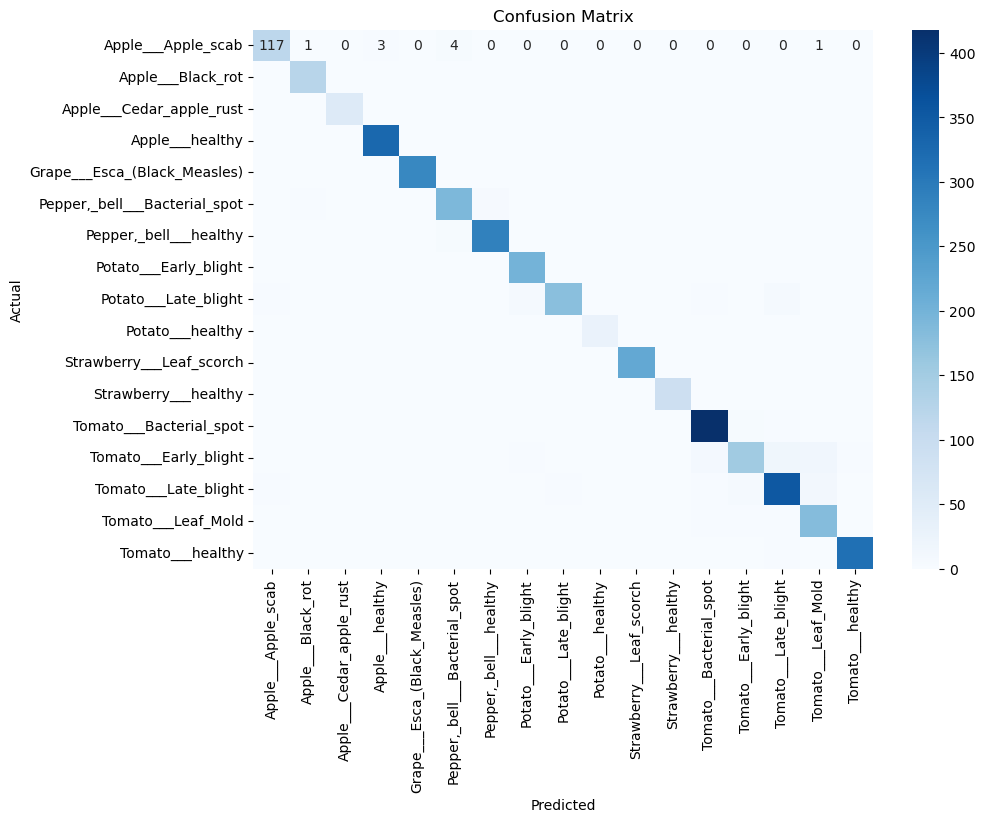

In [12]:
import seaborn as sns
#  Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

F1 Score: 0.9601


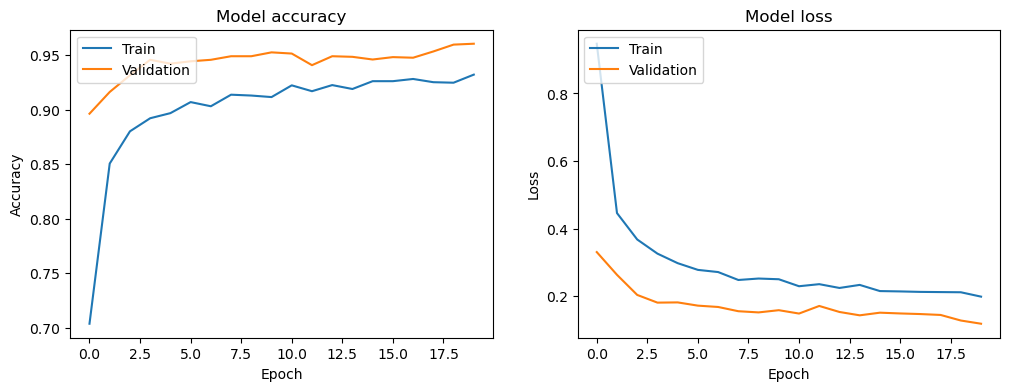

In [13]:
#  Additional Metrics
from sklearn.metrics import f1_score

f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

#  plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [14]:
model.save(r'E:\DATA SETS\MobileNetv2 comparison 12K\Model.keras')